In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib as ta
import optuna
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

/home/kanai/btcb/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
csv_use_cols = ["Open", "High", "Low", "Close", "Volume"]
shift = 5
csvfilename = "../data/gmo/gmo_data.csv"

0               NaN
1         -0.000003
2          0.000006
3         -0.000003
4          0.000000
             ...   
1265847   -0.000165
1265848   -0.000116
1265849   -0.000209
1265850    0.000000
1265851    0.000746
Name: diff_ratio, Length: 1265852, dtype: float64


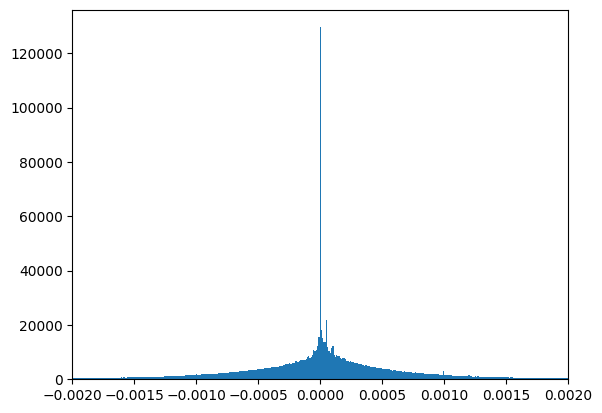

/home/kanai/btcb/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in label_func (vectorized)
  outputs = ufunc(*inputs)


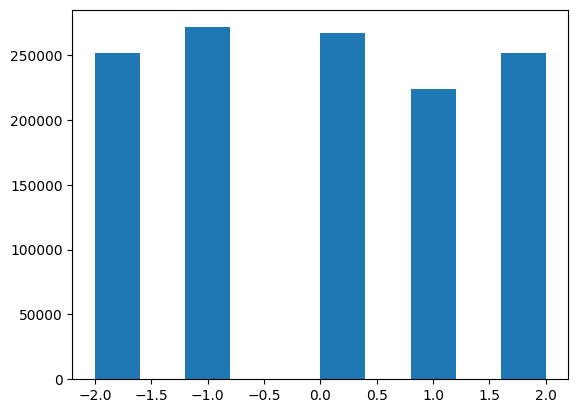

In [3]:
def label_func(x):
    if x > 0.00045: return 2
    elif x < -0.00045: return -2
    elif x > 0.000095: return 1
    elif x < -0.000015: return -1
    else: return 0

df = pd.read_csv(csvfilename,usecols=csv_use_cols)

df["diff_ratio"] = df["Close"].diff()/df["Close"]
print(df["diff_ratio"])
plt.hist(df["diff_ratio"], bins=10000)
plt.xlim(-0.002,0.002)
plt.show()
df["target"] = np.vectorize(label_func)(df["diff_ratio"])
plt.hist(df["target"])
plt.show()
df["target"] = df["target"].shift(-1)

In [4]:
df["EMA5"] = ta.EMA(df["Close"], timeperiod=5)
df["EMA50"] = ta.EMA(df["Close"], timeperiod=50)
df["EMA200"] = ta.EMA(df["Close"], timeperiod=200)
df["RSI"] = ta.RSI(df["Close"], timeperiod=14)
df["MFI"] = ta.MFI(df["High"], df["Low"], df["Close"], df["Volume"], timeperiod=14)

for i in range(0, shift+1):
    df["Open-{0}ratio".format(i)] = df["Open"].shift(i)/df["Close"]
    df["High-{0}ratio".format(i)] = df["High"].shift(i)/df["Close"]
    df["Low-{0}ratio".format(i)] = df["Low"].shift(i)/df["Close"]
    df["Close-{0}ratio".format(i)] = df["Close"].shift(i)/df["Close"]
    df["EMA5-{0}ratio".format(i)] = df["EMA5"].shift(i)/df["Close"]
    df["EMA50-{0}ratio".format(i)] = df["EMA50"].shift(i)/df["Close"]
    df["EMA200-{0}ratio".format(i)] = df["EMA200"].shift(i)/df["Close"]
    df["Volume-{0}".format(i)] = df["Volume"].shift(i)
    df["RSI-{0}".format(i)] = df["RSI"].shift(i)
    df["MFI-{0}".format(i)] = df["MFI"].shift(i)

df.dropna(axis=0,inplace=True)
df.reset_index(drop=True, inplace=True)

In [5]:
print(df["target"].value_counts())

mlcols = []
for i in range(0, shift+1):
    mlcols.append("Open-{0}ratio".format(i))
    mlcols.append("High-{0}ratio".format(i))
    mlcols.append("Low-{0}ratio".format(i))
    mlcols.append("Close-{0}ratio".format(i))
    mlcols.append("EMA5-{0}ratio".format(i))
    mlcols.append("EMA50-{0}ratio".format(i))
    mlcols.append("EMA200-{0}ratio".format(i))
    mlcols.append("Volume-{0}".format(i))
    mlcols.append("RSI-{0}".format(i))
    mlcols.append("MFI-{0}".format(i))

X = df[mlcols]
Y = df["target"]
print(X.describe())
print(X.info)
print(Y.describe())
print(Y.info)
xgbtraindata = xgb.DMatrix(data=X, label=Y)

target
-1.0    271340
 0.0    267128
 2.0    251811
-2.0    251226
 1.0    224142
Name: count, dtype: int64
        Open-0ratio   High-0ratio    Low-0ratio  Close-0ratio   EMA5-0ratio  \
count  1.265647e+06  1.265647e+06  1.265647e+06     1265647.0  1.265647e+06   
mean   1.000005e+00  1.000247e+00  9.997428e-01           1.0  1.000001e+00   
std    8.396133e-04  6.535684e-04  6.529839e-04           0.0  8.888398e-04   
min    9.499606e-01  1.000000e+00  9.450980e-01           1.0  9.622807e-01   
25%    9.998930e-01  1.000000e+00  9.997596e-01           1.0  9.996631e-01   
50%    1.000000e+00  1.000000e+00  1.000000e+00           1.0  9.999826e-01   
75%    1.000084e+00  1.000203e+00  1.000000e+00           1.0  1.000322e+00   
max    1.045946e+00  1.049957e+00  1.000000e+00           1.0  1.059526e+00   

       EMA50-0ratio  EMA200-0ratio      Volume-0         RSI-0         MFI-0  \
count  1.265647e+06   1.265647e+06  1.265647e+06  1.265647e+06  1.265647e+06   
mean   1.000007e+00 

In [6]:
def objective(trial,df_X,df_y):
    params ={
        'max_depth':trial.suggest_int("max_depth",3,12),
        'min_child_weight':trial.suggest_int('min_child_weight',1,5),
        'gamma':trial.suggest_float('gamma',0,1),
        'subsample':trial.suggest_float('subsample',0,1),
        'colsample_bytree':trial.suggest_float('colsample_bytree',0,1),
        'reg_alpha':trial.suggest_float('reg_alpha',1e-5,100,log=True),
        'reg_lambda':trial.suggest_float('reg_lambda',1e-5,100,log=True),        
        'learning_rate':trial.suggest_float('learning_rate',0,0.7),
        'device':'gpu',
        'tree_method':'hist',
    }
    
    model = xgb.XGBRegressor(**params)
    scores = cross_val_score(model, df_X, df_y, scoring='neg_mean_squared_error', cv=5)
    score_mean = -1*np.mean(scores)
    
    return score_mean

In [7]:
study = optuna.create_study()
study.optimize(lambda trial: objective(trial,X,Y), n_trials=1)
print("best params")
print(study.best_params)

[I 2024-08-31 15:42:08,287] A new study created in memory with name: no-name-3ac5ad86-8f4b-4712-82c5-505fc08914ae
/home/kanai/btcb/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:42:10] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
[I 2024-08-31 15:42:17,628] Trial 0 finished with value: 2.0414341834592666 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.2611670110877826, 'subsample': 0.041956735897705655, 'colsample_bytree': 0.6504399235202504, 'reg_alpha': 0.00011291396455965291, 'reg_lambda': 0.00029268816771179073, 'learni

best params
{'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.2611670110877826, 'subsample': 0.041956735897705655, 'colsample_bytree': 0.6504399235202504, 'reg_alpha': 0.00011291396455965291, 'reg_lambda': 0.00029268816771179073, 'learning_rate': 0.20586344710097132}


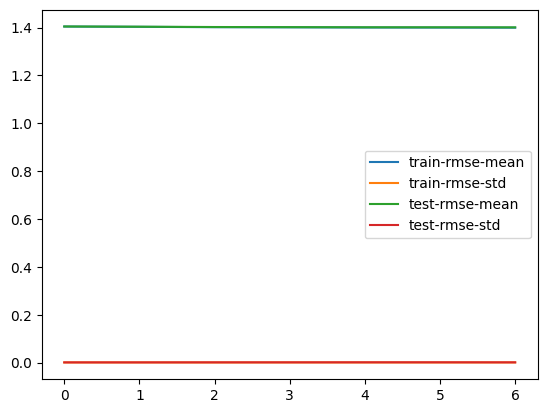

In [8]:
params = study.best_params
dd = xgb.cv(params, xgbtraindata, num_boost_round=10000, early_stopping_rounds=100, nfold=4, metrics='rmse', seed=0)
plt.plot(dd)
plt.legend(dd.columns)
plt.show()

MSE
1.916990268692013


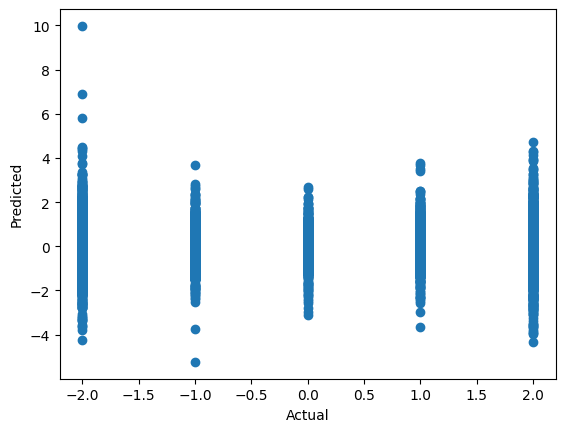

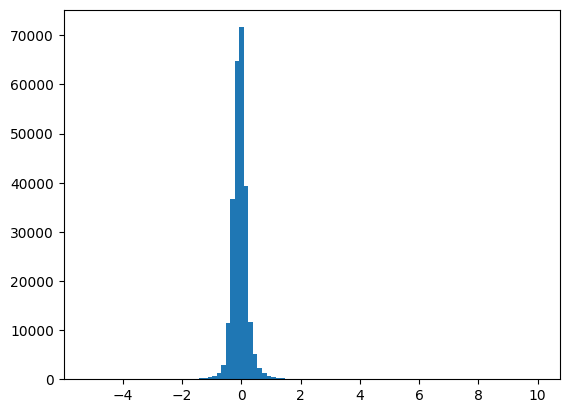

<Figure size 5000x5000 with 0 Axes>

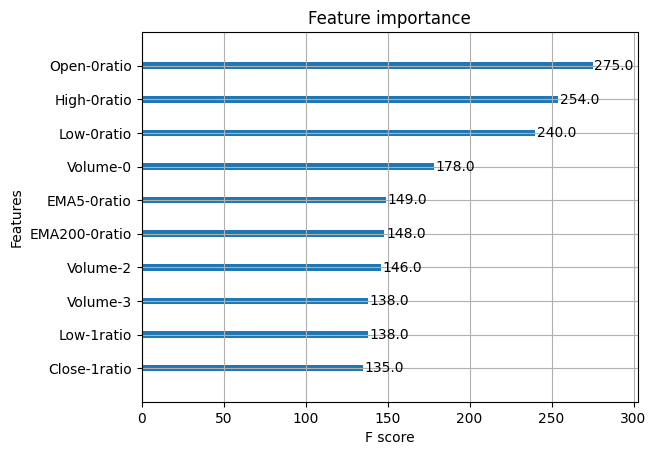

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)
model = XGBRegressor(objective='reg:squarederror', **params)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print("MSE")
print(mean_squared_error(Y_test, Y_pred))
plt.scatter(Y_test, Y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

plt.hist(Y_pred, bins=100)
plt.show()

fig = plt.figure(figsize=(100,100),dpi=50)
plot_importance(model, max_num_features=10)
plt.rcParams["figure.figsize"] = [100,100]
plt.show()